# Interactive DataMapPlot Selection and Filtering

This notebook will get you started on using selection and filtering tools in DataMapPlot interactive plots. There is a lot that can be done, so this notebook will instead highlight some of the major options and walk through some simple examples to get you started on building your own selection options. To get started we’ll need to import DataMapPlot.

In [1]:
import datamapplot

To demonstrate what DataMapPlot interactive plots can do we’ll need some data. The examples directory of the DataMapPlot repository contains some pre-prepared datasets for experimenting with. We’ll grab one of those. Much like the static plotting we need a data map – as set of 2d coordinates, one per data sample we are mapping – and at least one set of labels idenityfing the “topic” of a data sample, usually based on clusters in the data map. In this case we’ll use a data map derived from the CORD-19 dataset – a dataset of papers and scientific articles related to COVID-19 that was curated by Allen AI. To show off some of the filtering options we'll be sure to load some other associated metadata for the papers such as the primary field of research, the publication date, and the citation counts. All of this data is also available in the examples directory.

In [2]:
import numpy as np
import pandas as pd
import requests
import bz2
import io

base_url = "https://github.com/TutteInstitute/datamapplot"

data_map_file = requests.get(
    f"{base_url}/raw/main/examples/cord19_umap_vectors.npy"
)
cord19_data_map = np.load(io.BytesIO(data_map_file.content))
cord19_label_layers = []
for i in range(6):
    label_file = requests.get(
        f"{base_url}/raw/main/examples/cord19_layer{i}_cluster_labels.npy"
    )
    cord19_label_layers.append(
        np.load(io.BytesIO(label_file.content), allow_pickle=True)
    )
hover_text_file = requests.get(
    f"{base_url}/raw/main/examples/cord19_large_hover_text.txt.bz2"
)
cord19_hover_text = np.array([
    x.decode("utf-8").strip()
    for x in bz2.open(io.BytesIO(hover_text_file.content))
])
cord19_extra_data = pd.read_feather(f"{base_url}/raw/main/examples/cord19_extra_data.arrow")
date_file = requests.get(
    f"{base_url}/raw/main/examples/CORD19-subset-publish-dates.npy"
)
cord19_publication_date = np.load(io.BytesIO(date_file.content))
cord19_extra_data["publication_date"] = pd.Series(cord19_publication_date)
cord19_extra_data["publication_date"] = cord19_extra_data.publication_date.fillna(cord19_extra_data.publication_date.max()).dt.as_unit('s')

To begin let's make a basic interactive plot. By this point we'll assume you are more familiar with some of the interactive plotting options, so we'll make use of them to make a good looking plot that includes hover information and is searchable. This will provide the baseline that we'll add first filtering and later selection options to.

<div class="alert alert-block alert-info">
<b>Tip:</b> Due to the larger datasets and a desire to keep the documentation pages smaller, this tutorial makes use of the <code>inline_data=False</code> directive to ensure all the data for all the plots are not embedded in a single page. This can cause issues, and does not work (for example) on Colab. If you are having issues running this notebook, try removing the <code>inline_data=False</code> keyword arguments and see if that helps! Also note that this means some of the exampes on the documentation page can take quite a while to load. Please be patient.</div>

<InteractiveFigure width=100% height=800>
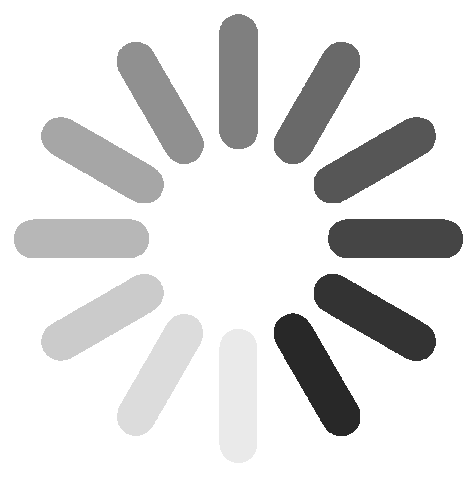

In [3]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-1",
    initial_zoom_fraction=0.9,
)
plot

Suppose we want to look at the data for varying citation counts. We could colour the data according to citation count, but that will likely be messy and hard to see. Likewise sizing points in relation to citation count can work, but does a poorer job at letting you quickly see where all the high citation count papers reside. A better approach would be to provide a filtering tool that shows the distribution of citation counts and lets you select from there. To do this we can add the citation count information as ``histogram_data``. Since citation counts have a power-law-like distribution we'll make things a little easier by looking at the log of the citation counts.

<InteractiveFigure width=100% height=800>
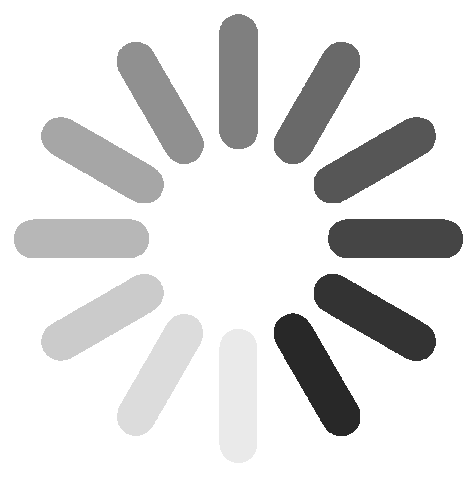

In [4]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-2",
    initial_zoom_fraction=0.9,
    histogram_data=np.log10(1 + cord19_extra_data.citation_count),
)
plot

The resulting interactive plot has a histogram in the bottom left corner, showing the distirbution of (log of) citation counts. If you hover your mouse over individual bins in the histogram the data map will update to display only the points in that bin, letting you quickly view the relative positions in the datamap. Moreover, by clicking and dragging in the histogram you can create a selection box to create a persistent selection of some number of bins. The selection box can be resized or dragged around the histogram, with the selection updating in realtime.

It is also worth noting that we have the seach feature in the upper right -- we can do a text search on the titles of the papers. This search actually interacts with the histogram. If no histogram selection is made the histogram will update to show the distribution of items matching the search. Now hovering selects only items in the bix that also match the search. Similarly selections within the histogram result in only results that match both the text search and the histogram selection filtering. It is worth playing around a little with this, to see how the interaction between the two ways of selecting/filtering points in the data map works.

Of course we may wish to look at distributions of something that isn't a standard numeric value. What if we want to look at dates or times? This would be a very common use case -- being able to filter a data map by the date or time a certain data sample was created or measured is very valuable. Let's see what happens when we pass in the publication dates of the papers as ``histogram_data``. While we are at it, let's use some of the other historgam options, such as setting the number of histogram bins to use.

<InteractiveFigure width=100% height=800>
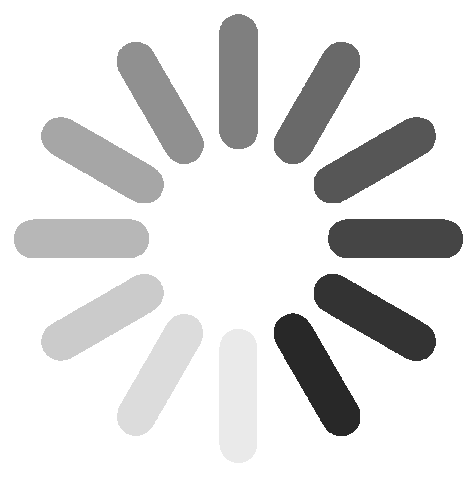

In [5]:
datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-3",
    initial_zoom_fraction=0.9,
    histogram_data=cord19_extra_data.publication_date,
    histogram_n_bins=12
)

We see that the dates were handled just fine -- the histogram is relatively data aware, and can work with dates and times natively. Again it is worth verifying that filtering works as before, and that interactions with the text search are indeed easy.

We do have an obvious problem though. Since the data collected any papers relevant to COVID-19 it includes some very old papers dating back to the 70s. The reality is that almost all of the actual data lands in a range much closer to 2019-2021. It would be good if we could actually pick a range for the hostogram. Fortunately we can via the ``histogram_range`` option which takes a tuple of values -- the start and end for the histogram. Items that fall outside the histogram range specified will be placed in either the first, or last, bin in the historgam, depending on whether they are below or above the range respectively. In our case, since the data is actually dates we will need to generate pandas datetime objects for the start and end of our range (if the data was numeric we could simply specify numeric values directly).

Another issue was choosing a number of bins -- while that can work for arbitrary numeric ranges, dates and times are special, so it would be nice to be able to have the data bins meet with those categories. It would be good, for example, to bin dates by the month or year, or times by the hour, minute or second (depeding on the time range of the data). For this we have the ``histogram_group_datetime_by`` option which takes a time unit (``"year"``, ``"quarter"``, ``"month"``, ``"day"``, ``"hour"``, ``"minute"`` or ``"second"``) to group by. Give the kind of time range we are looking at grouping by quarter makes sense.

<InteractiveFigure width=100% height=800>
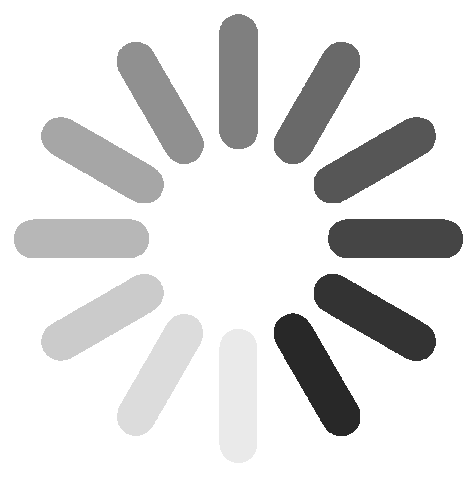

In [6]:
datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-4",
    initial_zoom_fraction=0.9,
    histogram_data=cord19_extra_data.publication_date,
    histogram_group_datetime_by="quarter",
    histogram_range=(pd.to_datetime("2019-09-01"), pd.to_datetime("2022-01-01"))
)

We get a better looking histogram thsi tiem around, showing more of the range of data. We do have a little problem with pre-2019 data being piled into the bottom-most bin, but we can overlook that for now. We see that there was a major peak in publication in the last quarter of 2020, and selection shows it ws pretty evenly distribuetd over all the different fields and topics. Hopefully this suffices as a demo of the date-time handlign capabilities of histograms.

Let's move on to another data type -- purely categorical data. What happens if we provide the primary field of research of the papers as ``histogram_data``? There are actually a surprisingly diverse range of fields included in the dataset. Let's keep the number of bins down to 15. When we specify the number of bins for categorical data like this it will take the top 15 categories, and lump the rest of the data into a special "Other" category.  Since this is the last histogram example we're goign to do, let's also make use of it to show some of the further options with the ``histogram_settings`` which allow you control over the size and presentation of the histogram. We'll even put the y-axis of the histogram on a log-scale (since many of the fields have relatively few papers, and it would be hard to see them on a linear scale).

<InteractiveFigure width=100% height=800>
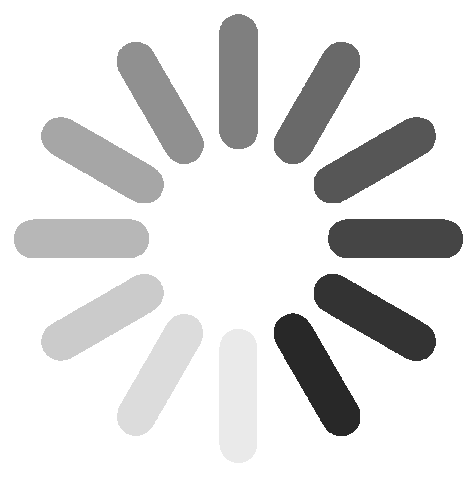

In [7]:
datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-5",
    initial_zoom_fraction=0.9,
    histogram_data=cord19_extra_data.primary_field,
    histogram_n_bins=15,
    histogram_settings={
        "histogram_log_scale":True,
        "histogram_title":"Primary Field",
        "histogram_bin_fill_color":"#a64531",
        "histogram_bin_unselected_fill_color":"#d6a591",
        "histogram_bin_selected_fill_color":"#f68571",
        "histogram_width":400,
        "histogram_height":125,
    }
)

That was a whirlwind tour of the filtering options available via histograms in DataMapPlot. Hopefully it is enough to get you started. Please consult the doctsrings or API docs for more information about the parameters and options available to get the most out of your filtering histograms.

Now let's turn to other ways to select data. DataMapPlot supports lasso-style selection of points. This is turned off unless a way to handle such a selection is provided. For that we'll need to load an extra module of selection handlers.

In [8]:
import datamapplot.selection_handlers

The ``selection_handlers`` module provides some pre-built tools for reacting to lasso selections in an interactive data map. Currently the list is small, but hopefully it will grow over time. If a selection handler is instatiated and passed to ``create_interactive_plot`` as a ``selection_handler`` it will enable lasso selection for the plot, with lasso selections resulting in callbacks in the handler being called. A very simple selection handling option is to simply open a side-pane that provides a list of a sample of (hover_text of) items in the selection. The ``selection_handlers`` module has one of these called ``DisplaySample`` which we can instantiate, setting the number of items to randomly sample to 50. To make a selection in the resulting data map, once the map is loaded, hold down the shift key and draw a lasso with your mouse.

<InteractiveFigure width=100% height=800>
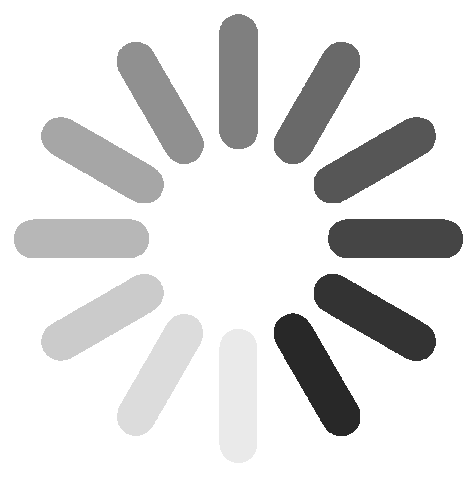

In [9]:
datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-6",
    initial_zoom_fraction=0.9,
    selection_handler=datamapplot.selection_handlers.DisplaySample(n_samples=50)
)

That's very nice, and can provide some utility, but it is likely that you have a rather more particular task in mind for acting on selections. That's okay, because you can build your own selection handler. It will involve a little javascript (and possibly HTML and CSS), but hopefully the results will be worth it. To understand what is required let's start with the just about the simplest possible selection handler. We need to create a new class that inherits from ``datamapplot.selection_handlers.SelectionHandlerBase``. We can then add various properties to it to enable it to do things upon selection. The most critical of these is ``javascript`` which should be a property that returns a string of javascript code to be used for handling selections. The critical thing here is that it must define a function called ``lassoSelectionCallback`` that will get called upon the completion of a lasso selection. It should take a parameter ``selectedIndices`` that will be an array of indices of the points selected by the lasso. For our simple case we can simply raise an alert that gives the number of items in the selection.

In [10]:
class NewSelectionHandler (datamapplot.selection_handlers.SelectionHandlerBase):

    @property
    def javascript(self):
        return """
function lassoSelectionCallback(selectedIndices) {
    alert("Lasso selection selected " + selectedIndices.length + " total points");
}
"""

Now that we have created a new selection handler class we can pass that in as a ``selection_handler`` to ``create_interactive_plot``. 

<InteractiveFigure width=100% height=800>
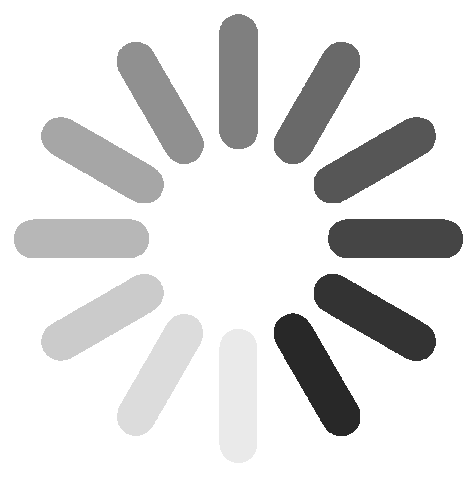

In [11]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-6",
    initial_zoom_fraction=0.9,
    selection_handler=NewSelectionHandler()
)
plot

The result is that when you use shift-lasso-drag to select points in the plot a popup message in the browser will inform your of the number of points selected. This is often a modal dialog, so you'll have to clear it by hitting "okay" or similar before seelecting again. Nonetheless this gives the core skeleton for creating a selection handler -- we need a javascript function ``lassoSelectionCallback`` that can take a array of indices and do something with it. As long as you can write a little javascript you can arrange for interesting things to happen upon selection.

Let's get a little more fancy. Using the alert function is not ideal. It would be better if we could have some HTML element on the page show the information we want. So let's do that. As before we'll need to create a class inheriting from ``datamapplot.selection_handlers.SelectionHandlerBase``, and a javascript function ``lassoSelectionCallback`` to operate upon the selection. Now, however, since we want to display results in the actual HTML output, we'll also need some HTML and CSS elements. These can be added as properties for the class, similarly to the ``javascript`` property. 

We'll need a ``div`` to put any output in, ideally with some id or class so we can style it, and reference it from the javascript. In this case I'll use an id but I'll set the class to be ``'container-box'`` which will ensure it is styled to match other items such as the title, search box, or logo -- this is a class defined by datamapplot, but worth using here. For the moment the ``div`` is simply empty. It will be up to the javascript function to add or alter the content of the div. All of this simply goes into the string returned by the ``html`` property.

Similarly we can create a ``css`` property that returns a string of CSS we wish to add to the eventual output. In this case we'll simply place the ``div``, based on its id, in the bottom right, set a font-size, and ensure it resizes itself to fit whatever the content of the ``div`` is.

Lastly we need to have our ``lassoSelectionCallback`` actually do something. The first step is to get the relevant ``div`` based on the id we set for it in the HTML. Next we set the ``innerHTML`` to be a giving the count of how many points were selected. And that's it -- the content of the div will now be reactive to the lasso selection, updating the text with each new selection made.

In [12]:
class NewSelectionHandler (datamapplot.selection_handlers.SelectionHandlerBase):

    @property
    def javascript(self):
        return """
function lassoSelectionCallback(selectedIndices) {
    const countDisplayContainer = document.getElementById("count-display");
    countDisplayContainer.innerHTML = "Lasso selection selected " + selectedIndices.length + " total points";
}
"""
    @property
    def html(self):
        return "<div id='count-display' class='container-box'></div>"

    @property
    def css(self):
        return """
#count-display {
    position: absolute;
    right: 0;
    bottom: 0;
    width: fit-content;
    height: fit-content;
    font-size: 24;
}
"""

Now we simply add this new selection handler to a plot using the ``selection_handler`` parameter and we are good to go. You can test out that lasso selection indeed updates the text.

<InteractiveFigure width=100% height=800>
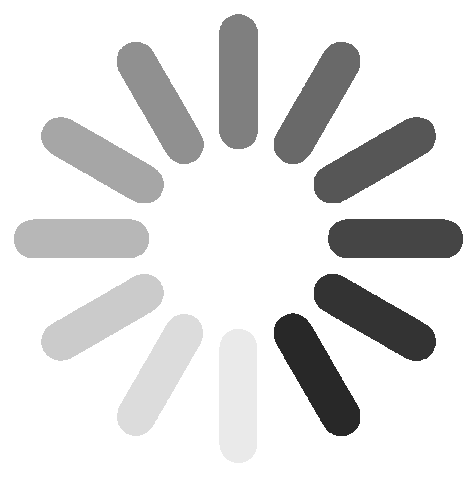

In [13]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-6",
    initial_zoom_fraction=0.9,
    selection_handler=NewSelectionHandler()
)
plot

That demonstrates the basic concepts involved in writing your own selection handler -- using javascript to update or change HTML elements based on the selection. And hopefully you now have some idea of how you might go abaout writing one of your own. It isn't a great demonstration of what can be done, however, nor how to access data beyond the specific indices of the selected points. To remedy that let's build something more complicated that actually does something interesting. Out of necessity this is going to be more complicated and involve more javascript, but I'll try to highlight the core elements that matter versus aspects that are just javascript to do useful work that are specific to this example.

First we need a goal. For a relatively simple demonstration that still does *something* let's try to create a word-cloud based on the selected items. That could easily turn into a lot of javascript code, but we can save ourselves a lot of work by making use of existing libraries. In this case there is a ``d3-cloud`` library that allows for dynamic word-clouds using the [d3](https://d3js.org) data visualization library. A catch is that we'll need those libraries loaded into the HTML file. We can do this by passing in a set of dependencies to the base class. With the visualization side hopefully made simpler, we just need some more basic javascript functions -- the ability to count occurrences of words in arrays of text, and the ability to remove stop-words (common words such as "the", "and", "or" etc.) from the output of that. We can use the English language stop word list from sklearn, and write a short function called ``wordCounter`` to handle the word counting. You can, of course, write whatever helper functions you need for your use case.

This brings us to actually writing the ``lassoSelectionCallback``. First we need to get the text associated to the selection. That kind data, along with any other "extra_point_data" is stored in ``datamap.metaData``, keyed by the column name. In our case we want the ``hover_text`` which has the text we get when hovering over items. We can translate from indices to actual content by mapping each index to the text in the ``datamap.metaData.hover_text`` array at that index via ``const selectedText = selectedPoints.map(i => datamap.metaData.hover_text[i]);``. Now we simply build word-counts from the array of texts using our helper function, and pass the results to another function that uses ``d3-cloud`` to make a word cloud.

As long as we ensure we have a ``div`` to place the word-cloud in (via the ``html`` property) and style it appropriately (via the ``css`` property) then we are essentially done.

In [14]:
import sklearn.feature_extraction.text
import string

class WordCloud (datamapplot.selection_handlers.SelectionHandlerBase):
    
    def __init__(self, n_words=256, width=300, height=400, stop_words=None, **kwargs):
        super().__init__(
            dependencies=[
                "https://d3js.org/d3.v6.min.js", 
                "https://unpkg.com/d3-cloud@1.2.7/build/d3.layout.cloud.js",
            ], 
            **kwargs
        )
        self.n_words = n_words
        self.width = width
        self.height = height
        self.stop_words = stop_words or list(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
 
    @property
    def javascript(self):
        return f"""
const _STOPWORDS = new Set({self.stop_words});
const svg = d3.select("#word-cloud").append("svg")
    .attr("width", {self.width})
    .attr("height", {self.height})
    .append("g")
    .attr("transform", "translate(" + {self.width} / 2 + "," + {self.height} / 2 + ")");
const wordCloudItem = document.getElementById("word-cloud");

function wordCounter(textItems) {{
    // Split words
    const words = textItems.join(' ').toLowerCase().split(/\s+/);
    
    // Count unique words
    const wordCounts = new Map();
    words.forEach(word => {{
        wordCounts.set(word, (wordCounts.get(word) || 0) + 1);
    }});
    
    // Remove stopwords, trim to the top words and rescale
    _STOPWORDS.forEach(stopword => wordCounts.delete(stopword));
    const result = Array.from(wordCounts, ([word, frequency]) => ({{ text: word, size: Math.sqrt(frequency) }}))
                        .sort((a, b) => b.size - a.size).slice(0, {self.n_words});
    const maxSize = Math.max(...(result.map(x => x.size)));
    return result.map(({{text, size}}) => ({{ text: text, size: (size / maxSize)}}));
}}

function generateWordCloud(words) {{
  const width = {self.width};
  const height = {self.height};

  // Configure a cloud layout
  const layout = d3.layout.cloud()
    .size([width, height])
    .words(words.map(d => ({{text: d.text, size: 5 + d.size * width / 10}})))
    .rotate(() => 0)
    .fontSize(d => d.size)
    .font("Impact")
    .on("end", draw);

  layout.start();

  function draw(words) {{
    // Update existing words
    const text = svg.selectAll("text")
      .data(words, d => d.text);
    
    // Remove old words
    text.exit()
      .remove();
      
    // Add new words
    text.enter()
      .append("text")
      .attr("text-anchor", "middle")
      .text(d => d.text)
      .merge(text)
      .attr("transform", d => "translate(" + [d.x, d.y] + ")rotate(" + d.rotate + ")")
      .attr("font-size", d => d.size)
      .attr("font-family", "Impact");
  }}
}}

function lassoSelectionCallback(selectedPoints) {{
    const selectedText = selectedPoints.map(i => datamap.metaData.hover_text[i]);
    const wordCounts = wordCounter(selectedText);
    generateWordCloud(wordCounts);
}}
        """

    @property
    def html(self):
        return """<div id="word-cloud" class="container-box"></div>"""

    @property
    def css(self):
        return f"""
#word-cloud {{
    position: absolute;
    right: 0;
    bottom: 0;
    width: {self.width}px;
    height: {self.height}px;
    font-family: Impact;
    z-index: 10;
}}
"""

A much more involved example, but mostly it is javascript code to do the work of parsing the text and building the word-cloud. We can now hand this off to ``create_interactive_plot`` and verify that it works. If you want to make adjustments to the above and try them out feel free. Be aware, however, that errors produced internally to the javascript will only show up in the javascript console (accessible in the "Developer Tools" for your browser), so be sure to check there if things seem to be silently failing to work as intended.

<InteractiveFigure width=100% height=800>
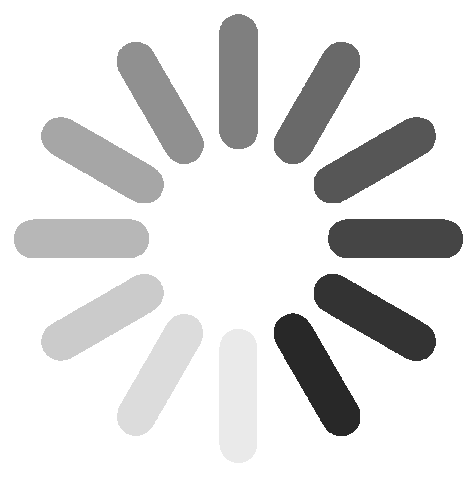

In [15]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-6",
    initial_zoom_fraction=0.9,
    selection_handler=WordCloud(256)
)
plot

That's a decent word cloud, but of course we can likely do better, and provide more options. Fortunately ``datamapplot.selection_handlers`` has a ``WordCloud`` handler pre-built that does he same as the above, but also much more, with more flexibility and better aesthetics. Here's an example of what we can do:

<InteractiveFigure width=100% height=800>
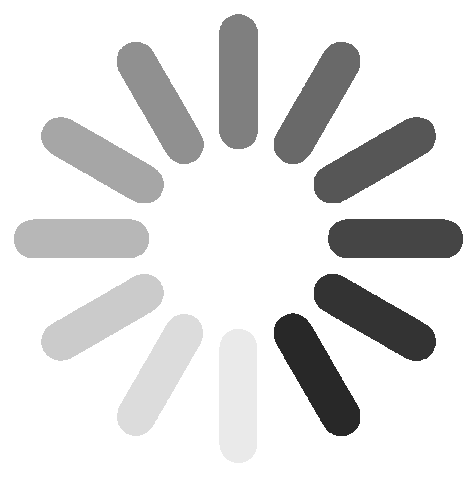

In [16]:
plot = datamapplot.create_interactive_plot(
    cord19_data_map,
    *cord19_label_layers,
    hover_text=cord19_hover_text,
    font_family="Cinzel",
    enable_search=True,
    inline_data=False,
    offline_data_prefix="cord-large-6",
    initial_zoom_fraction=0.9,
    selection_handler=datamapplot.selection_handlers.WordCloud(256, width=500, height=300, font_family="Cinzel", color_scale="viridis_r", n_rotations=0)
)
plot